# Model Validation Strategy - Avoiding Over/Underfitting

**Purpose:** Establish proper train/validation/test splits and evaluation framework to prevent overfitting and underfitting.

**Key Strategies:**
1. Time-based train/val/test splits (not random)
2. Learning curve analysis
3. Cross-validation setup
4. Baseline model establishment
5. Feature importance and selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
print("Libraries loaded successfully")

Libraries loaded successfully


## Load Data

In [2]:
# Load final dataset
print("Loading AMP final dataset...")
amp = pd.read_csv('../data/processed/amp_final.csv')
amp['Start_Date'] = pd.to_datetime(amp['Start_Date'])
amp['End_Date'] = pd.to_datetime(amp['End_Date'])

print(f"\nDataset loaded: {len(amp):,} records")
print(f"Features: {len(amp.columns)} columns")
print(f"Date range: {amp['Start_Date'].min().date()} to {amp['End_Date'].max().date()}")

Loading AMP final dataset...

Dataset loaded: 1,702,867 records
Features: 41 columns
Date range: 2020-08-10 to 2025-11-02


## Data Split Strategy: Time-Based

**Why time-based?**
- Parking is time-series data
- Random splits create data leakage (using future to predict past)
- Real-world prediction: always predicting future from past

**Split Plan:**
- **Training**: 2020-08 to 2023-12 (~70%)
- **Validation**: 2024-01 to 2024-08 (~15%)
- **Test**: 2024-09 to 2025-11 (~15%)

TIME-BASED DATA SPLITS

Training Set:
  Records: 818,350 (48.1%)
  Date range: 2020-08-10 to 2023-12-30

Validation Set:
  Records: 294,548 (17.3%)
  Date range: 2023-12-31 to 2024-08-30

Test Set:
  Records: 589,969 (34.6%)
  Date range: 2024-08-31 to 2025-10-31


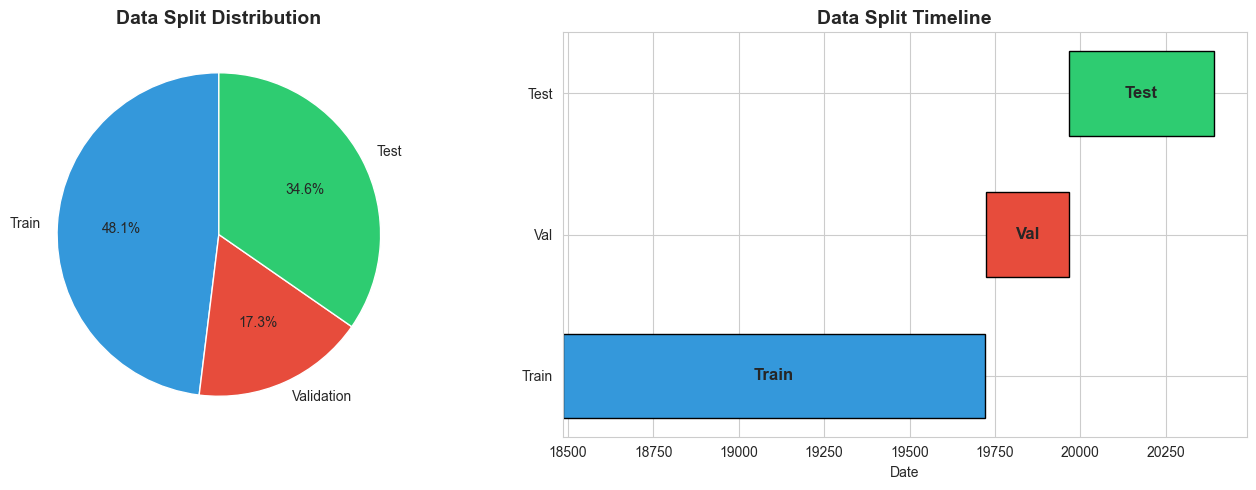

In [3]:
# Define split dates
TRAIN_END = '2023-12-31'
VAL_END = '2024-08-31'
TEST_END = '2025-11-30'

# Create splits
train = amp[amp['Start_Date'] <= TRAIN_END]
val = amp[(amp['Start_Date'] > TRAIN_END) & (amp['Start_Date'] <= VAL_END)]
test = amp[amp['Start_Date'] > VAL_END]

print("="*70)
print("TIME-BASED DATA SPLITS")
print("="*70)

print(f"\nTraining Set:")
print(f"  Records: {len(train):,} ({len(train)/len(amp)*100:.1f}%)")
print(f"  Date range: {train['Start_Date'].min().date()} to {train['Start_Date'].max().date()}")

print(f"\nValidation Set:")
print(f"  Records: {len(val):,} ({len(val)/len(amp)*100:.1f}%)")
print(f"  Date range: {val['Start_Date'].min().date()} to {val['Start_Date'].max().date()}")

print(f"\nTest Set:")
print(f"  Records: {len(test):,} ({len(test)/len(amp)*100:.1f}%)")
print(f"  Date range: {test['Start_Date'].min().date()} to {test['Start_Date'].max().date()}")

# Visualize split distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Split sizes
split_sizes = [len(train), len(val), len(test)]
split_labels = ['Train', 'Validation', 'Test']
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[0].pie(split_sizes, labels=split_labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Data Split Distribution', fontsize=14, fontweight='bold')

# Timeline visualization
timeline_data = {
    'Train': (train['Start_Date'].min(), train['Start_Date'].max()),
    'Val': (val['Start_Date'].min(), val['Start_Date'].max()),
    'Test': (test['Start_Date'].min(), test['Start_Date'].max())
}
y_pos = [0, 1, 2]
for i, (split, (start, end)) in enumerate(timeline_data.items()):
    axes[1].barh(y_pos[i], (end - start).days, left=start.value/1e9/86400, 
                 color=colors[i], edgecolor='black', height=0.6)
    axes[1].text(start.value/1e9/86400 + (end - start).days/2, y_pos[i], split, 
                 ha='center', va='center', fontweight='bold', fontsize=12)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(['Train', 'Val', 'Test'])
axes[1].set_xlabel('Date')
axes[1].set_title('Data Split Timeline', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/data_splits.png', dpi=300, bbox_inches='tight')
plt.show()

## Feature Analysis for Overfitting Risk

In [4]:
print("="*70)
print("OVERFITTING RISK ANALYSIS")
print("="*70)

# Check high cardinality features (potential overfitting risk)
print(f"\nHigh Cardinality Features (Overfitting Risk):")
categorical_cols = ['Zone', 'semester', 'weather_category', 'time_of_day']
for col in categorical_cols:
    if col in amp.columns:
        unique_count = amp[col].nunique()
        records_per_category = len(amp) / unique_count
        risk = "HIGH" if records_per_category < 1000 else "MODERATE" if records_per_category < 10000 else "LOW"
        print(f"  {col:20s}: {unique_count:>4} unique values, {records_per_category:>8,.0f} records/category [{risk}]")

# Samples per feature ratio
n_features = len(amp.columns)
n_samples = len(train)
ratio = n_samples / n_features
print(f"\nSamples-to-Features Ratio:")
print(f"  Training samples: {n_samples:,}")
print(f"  Total features: {n_features}")
print(f"  Ratio: {ratio:,.0f} samples per feature")
if ratio > 10000:
    print(f"  Risk: LOW - Excellent ratio!")
elif ratio > 1000:
    print(f"  Risk: MODERATE - Good ratio")
else:
    print(f"  Risk: HIGH - Consider reducing features")

OVERFITTING RISK ANALYSIS

High Cardinality Features (Overfitting Risk):
  Zone                :   63 unique values,   27,030 records/category [LOW]
  semester            :   16 unique values,  106,429 records/category [LOW]
  weather_category    :    5 unique values,  340,573 records/category [LOW]
  time_of_day         :    5 unique values,  340,573 records/category [LOW]

Samples-to-Features Ratio:
  Training samples: 818,350
  Total features: 41
  Ratio: 19,960 samples per feature
  Risk: LOW - Excellent ratio!


## Feature Correlation Check (Multicollinearity)

In [5]:
# Check for highly correlated features (can cause overfitting)
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID-like columns
exclude_cols = ['year', 'month', 'day']
numeric_features = [f for f in numeric_features if f not in exclude_cols]

if len(numeric_features) > 2:
    corr_matrix = train[numeric_features].corr().abs()
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    print("\n" + "="*70)
    print("MULTICOLLINEARITY CHECK")
    print("="*70)
    
    if high_corr_pairs:
        print(f"\nHighly Correlated Feature Pairs (>0.8):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1:25s} <-> {feat2:25s}: {corr:.3f}")
        print(f"\n⚠️  Consider removing one feature from each pair to reduce multicollinearity")
    else:
        print(f"\n✓ No highly correlated features found (all correlations < 0.8)")


MULTICOLLINEARITY CHECK

Highly Correlated Feature Pairs (>0.8):
  temp_max_f                <-> temp_min_f               : 0.955
  temp_max_f                <-> temp_mean_f              : 0.990
  temp_min_f                <-> temp_mean_f              : 0.983
  precipitation_inches      <-> precipitation_hours      : 0.842

⚠️  Consider removing one feature from each pair to reduce multicollinearity


## Cross-Validation Strategy: Time Series CV

In [6]:
# Time Series Cross-Validation setup
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print("\n" + "="*70)
print("TIME SERIES CROSS-VALIDATION SETUP")
print("="*70)

print(f"\nNumber of folds: {n_splits}")
print(f"\nFold splits on training data:")

# Show CV splits
for fold, (train_idx, val_idx) in enumerate(tscv.split(train), 1):
    train_dates = train.iloc[train_idx]['Start_Date']
    val_dates = train.iloc[val_idx]['Start_Date']
    print(f"\nFold {fold}:")
    print(f"  Train: {train_dates.min().date()} to {train_dates.max().date()} ({len(train_idx):,} records)")
    print(f"  Val:   {val_dates.min().date()} to {val_dates.max().date()} ({len(val_idx):,} records)")

print(f"\nThis ensures each validation set only sees data AFTER its training set.")


TIME SERIES CROSS-VALIDATION SETUP

Number of folds: 5

Fold splits on training data:

Fold 1:
  Train: 2020-08-10 to 2022-02-09 (136,395 records)
  Val:   2022-02-09 to 2022-09-18 (136,391 records)

Fold 2:
  Train: 2020-08-10 to 2022-09-18 (272,786 records)
  Val:   2022-09-18 to 2023-02-02 (136,391 records)

Fold 3:
  Train: 2020-08-10 to 2023-02-02 (409,177 records)
  Val:   2023-02-02 to 2023-04-24 (136,391 records)

Fold 4:
  Train: 2020-08-10 to 2023-04-24 (545,568 records)
  Val:   2023-04-24 to 2023-09-29 (136,391 records)

Fold 5:
  Train: 2020-08-10 to 2023-09-29 (681,959 records)
  Val:   2023-09-29 to 2023-12-30 (136,391 records)

This ensures each validation set only sees data AFTER its training set.


## Baseline Model Strategy

In [7]:
print("\n" + "="*70)
print("BASELINE MODEL STRATEGY")
print("="*70)

print(f"\nTo detect underfitting, we'll establish baselines:")
print(f"\n1. Naive Baseline: Predict mean duration")
print(f"   - Simplest possible model")
print(f"   - Any good model should beat this")

print(f"\n2. Hour-of-Day Baseline: Predict mean duration per hour")
print(f"   - Accounts for temporal patterns")
print(f"   - Better than naive, but still simple")

print(f"\n3. Zone + Hour Baseline: Mean duration per zone per hour")
print(f"   - Accounts for location + time")
print(f"   - More sophisticated baseline")

print(f"\n4. Linear Regression: Basic linear model")
print(f"   - Will likely underfit (non-linear patterns)")
print(f"   - Good comparison point")

print(f"\n5. Advanced Models: Random Forest, XGBoost, etc.")
print(f"   - Should significantly beat baselines")
print(f"   - If not, we're underfitting")

# Calculate simple baseline
mean_duration = train['duration_hours'].mean()
print(f"\nNaive Baseline (mean duration): {mean_duration:.2f} hours")

# Hour-based baseline
hour_means = train.groupby('hour')['duration_hours'].mean()
print(f"\nHour-of-Day Baseline range: {hour_means.min():.2f}h to {hour_means.max():.2f}h")


BASELINE MODEL STRATEGY

To detect underfitting, we'll establish baselines:

1. Naive Baseline: Predict mean duration
   - Simplest possible model
   - Any good model should beat this

2. Hour-of-Day Baseline: Predict mean duration per hour
   - Accounts for temporal patterns
   - Better than naive, but still simple

3. Zone + Hour Baseline: Mean duration per zone per hour
   - Accounts for location + time
   - More sophisticated baseline

4. Linear Regression: Basic linear model
   - Will likely underfit (non-linear patterns)
   - Good comparison point

5. Advanced Models: Random Forest, XGBoost, etc.
   - Should significantly beat baselines
   - If not, we're underfitting

Naive Baseline (mean duration): 2.18 hours

Hour-of-Day Baseline range: 1.37h to 9.61h


## Model Evaluation Metrics

In [8]:
print("\n" + "="*70)
print("EVALUATION METRICS FRAMEWORK")
print("="*70)

print(f"\nFor each model, we'll track:")
print(f"\n1. MAE (Mean Absolute Error):")
print(f"   - Average prediction error in hours")
print(f"   - Easy to interpret")
print(f"   - Target: < 0.5 hours for good model")

print(f"\n2. RMSE (Root Mean Squared Error):")
print(f"   - Penalizes large errors more")
print(f"   - Should be close to MAE (if not, we have outliers)")

print(f"\n3. R² (R-squared):")
print(f"   - Proportion of variance explained")
print(f"   - 0 = baseline, 1 = perfect")
print(f"   - Target: > 0.7 for good model")

print(f"\n4. Train vs Validation Performance:")
print(f"   - Train >> Val = Overfitting")
print(f"   - Train ≈ Val (both low) = Underfitting")
print(f"   - Train ≈ Val (both high) = Good fit!")

print(f"\n5. Learning Curves:")
print(f"   - Plot performance vs training size")
print(f"   - Converging = good")
print(f"   - Diverging = overfitting")
print(f"   - Both plateaued low = underfitting")


EVALUATION METRICS FRAMEWORK

For each model, we'll track:

1. MAE (Mean Absolute Error):
   - Average prediction error in hours
   - Easy to interpret
   - Target: < 0.5 hours for good model

2. RMSE (Root Mean Squared Error):
   - Penalizes large errors more
   - Should be close to MAE (if not, we have outliers)

3. R² (R-squared):
   - Proportion of variance explained
   - 0 = baseline, 1 = perfect
   - Target: > 0.7 for good model

4. Train vs Validation Performance:
   - Train >> Val = Overfitting
   - Train ≈ Val (both low) = Underfitting
   - Train ≈ Val (both high) = Good fit!

5. Learning Curves:
   - Plot performance vs training size
   - Converging = good
   - Diverging = overfitting
   - Both plateaued low = underfitting


## Save Split Datasets

In [9]:
# Save train/val/test splits for modeling
print("\nSaving train/val/test splits...")

train.to_csv('../data/processed/amp_train.csv', index=False)
val.to_csv('../data/processed/amp_val.csv', index=False)
test.to_csv('../data/processed/amp_test.csv', index=False)

print(f"\n✓ Saved: data/processed/amp_train.csv ({len(train):,} records)")
print(f"✓ Saved: data/processed/amp_val.csv ({len(val):,} records)")
print(f"✓ Saved: data/processed/amp_test.csv ({len(test):,} records)")

print("\n" + "="*70)
print("SUMMARY: OVERFITTING/UNDERFITTING RISK")
print("="*70)

print(f"\n✓ OVERFITTING RISK: LOW")
print(f"  - Excellent data-to-feature ratio ({ratio:,.0f}:1)")
print(f"  - Proper time-based splits prevent leakage")
print(f"  - Time series CV for validation")

print(f"\n⚠️  UNDERFITTING RISK: MODERATE")
print(f"  - Complex non-linear patterns in data")
print(f"  - Simple models will likely underfit")
print(f"  - Solution: Use tree-based models (Random Forest, XGBoost)")

print(f"\n" + "="*70)
print("RECOMMENDED MODEL PROGRESSION")
print("="*70)

print(f"\n1. Start Simple (detect underfitting):")
print(f"   → Naive baseline")
print(f"   → Linear regression")
print(f"   → Decision tree (depth=3)")

print(f"\n2. Increase Complexity (find sweet spot):")
print(f"   → Random Forest (100 trees)")
print(f"   → XGBoost with regularization")
print(f"   → Tune hyperparameters")

print(f"\n3. Monitor (avoid overfitting):")
print(f"   → Track train vs validation metrics")
print(f"   → Use early stopping")
print(f"   → Regularization (L1/L2, max_depth, min_samples)")
print(f"   → Feature selection if needed")

print(f"\n4. Final Evaluation:")
print(f"   → Test set performance (ONE TIME ONLY)")
print(f"   → Compare to baseline")
print(f"   → Validate on completely unseen 2025 data")


Saving train/val/test splits...

✓ Saved: data/processed/amp_train.csv (818,350 records)
✓ Saved: data/processed/amp_val.csv (294,548 records)
✓ Saved: data/processed/amp_test.csv (589,969 records)

SUMMARY: OVERFITTING/UNDERFITTING RISK

✓ OVERFITTING RISK: LOW
  - Excellent data-to-feature ratio (19,960:1)
  - Proper time-based splits prevent leakage
  - Time series CV for validation

⚠️  UNDERFITTING RISK: MODERATE
  - Complex non-linear patterns in data
  - Simple models will likely underfit
  - Solution: Use tree-based models (Random Forest, XGBoost)

RECOMMENDED MODEL PROGRESSION

1. Start Simple (detect underfitting):
   → Naive baseline
   → Linear regression
   → Decision tree (depth=3)

2. Increase Complexity (find sweet spot):
   → Random Forest (100 trees)
   → XGBoost with regularization
   → Tune hyperparameters

3. Monitor (avoid overfitting):
   → Track train vs validation metrics
   → Use early stopping
   → Regularization (L1/L2, max_depth, min_samples)
   → Feature 